In [4]:
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import xy
from rasterio.vrt import WarpedVRT
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy
from collections import OrderedDict

from shapely.geometry import Point

ImportError: dlopen(/Users/pdas47/courses/cuahsi_landlab/resnet/.condaenv/lib/python3.7/site-packages/rasterio/_base.cpython-37m-darwin.so, 0x0002): Symbol not found: _ZSTD_compressBound
  Referenced from: <BFC06822-0FF5-3311-8ECD-FB1AE1C722BC> /Users/pdas47/courses/cuahsi_landlab/resnet/.condaenv/lib/libgdal.30.dylib
  Expected in:     <CB89BFF8-F71C-3D3B-9ACD-55EAE25BDF26> /Users/pdas47/courses/cuahsi_landlab/resnet/.condaenv/lib/libblosc.1.21.1.dylib

In [4]:
PLOTTING_PROJ = ccrs.PlateCarree()
DIST_PROJ = "+proj=eqdc +lon_0=104.0625 +lat_1=6.2969703 +lat_2=25.8604163 +lat_0=16.0786933 +datum=WGS84 +units=m +no_defs"

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

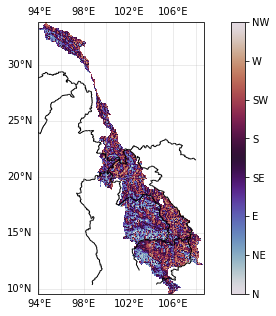

In [5]:
# read in the flow direction file
# fdr = rio.open("../data/thai_network/Thai-FDR.tif")
fdr = rio.open("../data/DRT_FDR_ARCfmt.tif")
band = fdr.read(1, masked=True)

direction_mapping = OrderedDict()
direction_mapping[1]= 3
direction_mapping[2]= 4
direction_mapping[4]= 5
direction_mapping[8]= 6
direction_mapping[16]= 7
direction_mapping[32]= 8
direction_mapping[64]= 1
direction_mapping[128]= 2
    
band_vicfmt = np.ma.MaskedArray(np.vectorize(direction_mapping.get)(band.data).astype(float), mask=band.mask)
# band_vicfmt = np.vectorize(direction_mapping.get)(band.data).astype(float)

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);


In [6]:
band_vicfmt

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

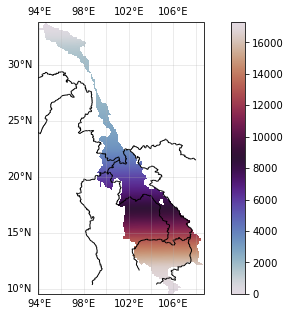

In [7]:
# create id of each cell
band_ids = np.full_like(band_vicfmt, np.nan)
_id = 0
for i in np.arange(band_vicfmt.shape[0]):
    for j in np.arange(band_vicfmt.shape[1]):
        if band_vicfmt[i][j] is not np.ma.masked:
            band_ids[i][j] = _id
            _id += 1
# band_ids = np.ma.MaskedArray(band_ids, mask=band)

band_ids
f, ax = geoax()
im = ax.imshow(band_ids, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)


<AxesSubplot:>

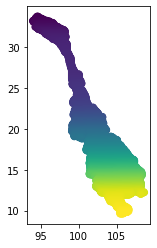

In [8]:
# create nodes
# extract x-y points
xs, _ = xy(fdr.transform, 0, np.arange(fdr.width))
_, ys = xy(fdr.transform, np.arange(fdr.height), 9)

XX, YY = np.meshgrid(xs, ys)

# create gdf
grid_pts = gpd.GeoDataFrame(data={'id': band_ids.flatten()}, geometry=[Point(x, y) for x, y in zip(XX.flatten(), YY.flatten())], crs='EPSG:4326')
grid_pts['to_id'] = np.nan

grid_pts.plot('id')


0.0 (0, 9) S  > | > 4.0 (1, 9)
1.0 (0, 10) S  > | > 5.0 (1, 10)
2.0 (0, 11) W  > | > 1.0 (0, 10)
3.0 (0, 12) N  > | > -- (-1, 12)
4.0 (1, 9) S  > | > 10.0 (2, 9)
5.0 (1, 10) W  > | > 4.0 (1, 9)
6.0 (1, 11) W  > | > 5.0 (1, 10)
7.0 (1, 12) W  > | > 6.0 (1, 11)
8.0 (1, 13) N  > | > -- (0, 13)
9.0 (2, 8) SE  > | > 19.0 (3, 9)
10.0 (2, 9) S  > | > 19.0 (3, 9)
11.0 (2, 10) W  > | > 10.0 (2, 9)
12.0 (2, 11) SW  > | > 20.0 (3, 10)
13.0 (2, 12) W  > | > 12.0 (2, 11)
14.0 (2, 13) W  > | > 13.0 (2, 12)
15.0 (2, 14) SW  > | > 23.0 (3, 13)
16.0 (3, 6) SE  > | > 26.0 (4, 7)
17.0 (3, 7) S  > | > 26.0 (4, 7)
18.0 (3, 8) S  > | > 27.0 (4, 8)
19.0 (3, 9) SW  > | > 27.0 (4, 8)
20.0 (3, 10) S  > | > 29.0 (4, 10)
21.0 (3, 11) W  > | > 20.0 (3, 10)
22.0 (3, 12) SW  > | > 30.0 (4, 11)
23.0 (3, 13) SW  > | > 31.0 (4, 12)
24.0 (3, 14) W  > | > 23.0 (3, 13)
25.0 (4, 6) E  > | > 26.0 (4, 7)
26.0 (4, 7) SE  > | > 41.0 (5, 8)
27.0 (4, 8) S  > | > 41.0 (5, 8)
28.0 (4, 9) S  > | > 42.0 (5, 9)
29.0 (4, 10) W  > | > 

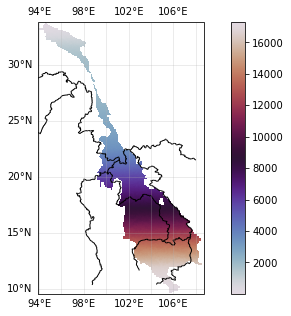

In [14]:
# create id of each cell
operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}
directions = {
    1: "N",
    2: "NE",
    3: "E",
    4: "SE",
    5: "S",
    6: "SW",
    7: "W",
    8: "NW"
}

to_band_ids = np.full_like(band_vicfmt, np.nan)
for x in np.arange(band_vicfmt.shape[0]):   
    for y in np.arange(band_vicfmt.shape[1]):  
        if band_vicfmt[x][y] is not np.ma.masked:
            direction = band_vicfmt[x][y]
            op = operations[direction]
            new_x, new_y = x + op[0], y + op[1]
            if new_x < band_ids.shape[0] and new_y < band_ids.shape[1]:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", band_ids[new_x, new_y], (new_x, new_y))
                to_band_ids[x, y] = band_ids[new_x, new_y]
            else:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", np.nan, (new_x, new_y))
                to_band_ids[x, y] = np.nan


# to_band_ids = np.ma.MaskedArray(to_band_ids, mask=band)

to_band_ids
f, ax = geoax()
im = ax.imshow(to_band_ids, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)


In [15]:
grid_pts['to_id'] = to_band_ids.flatten()

grid_pts.dropna(inplace=True)

grid_pts.head()

,id,geometry,to_id
9,0.0,POINT (94.46875 33.78125),4.0
10,1.0,POINT (94.53125 33.78125),5.0
11,2.0,POINT (94.59375 33.78125),1.0
246,4.0,POINT (94.46875 33.71875),10.0
247,5.0,POINT (94.53125 33.71875),4.0


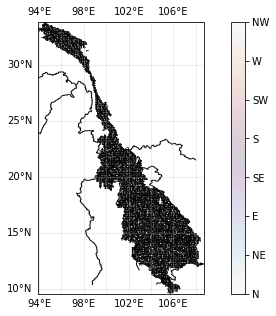

In [16]:
f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [17]:
root

id                            17299.0
geometry    POINT (105.78125 9.59375)
to_id                         17298.0
Name: 91909, dtype: object

Lets import the reservoir locations

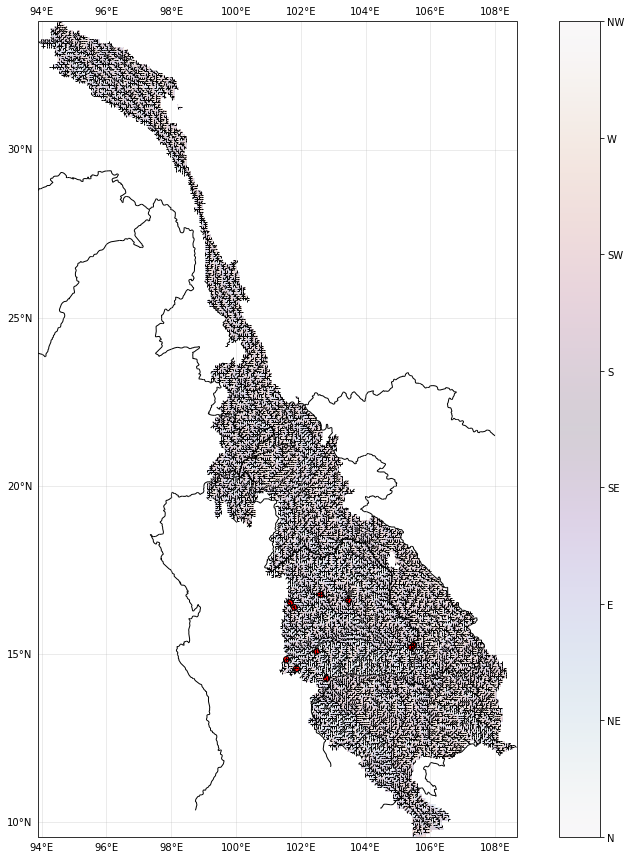

In [18]:
reservoirs_fn = "../data/thai_network/Thai-Stations-points-snapped-to-flow-lines.shp"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs_to_join = reservoirs[['name', 'lon', 'lat', 'geometry']]
grid_pts_joined_stns = grid_pts.to_crs(DIST_PROJ).sjoin_nearest(reservoirs_to_join.to_crs(DIST_PROJ), how='left', distance_col='dist [m]').to_crs('epsg:4326')

grid_pts_joined_stns['min_dist'] = grid_pts_joined_stns.groupby('name')['dist [m]'].transform('min')
grid_pts_joined_stns.loc[grid_pts_joined_stns['dist [m]'] != grid_pts_joined_stns['min_dist'], ['index_right', 'name', 'lon', 'lat', 'dist [m]', 'min_dist']] = np.nan

grid_pts_joined_stns

# plot on top of previous plot
f, ax = geoax(figsize=(15, 15))
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

grid_pts_joined_stns.dropna().plot(ax=ax, fc='red', ec='k')

gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

now we need a function that can (1) join two reservoir locations based on the network we have. (2) assign the length of travel by summing the length between the points

In [22]:
# %load_ext autoreload
# %autoreload 1
# # from regulation.regulation import *
# %aimport regulation
# Reservoir = regulation.regulation.Reservoir

In [23]:
root

id                            17299.0
geometry    POINT (105.78125 9.59375)
to_id                         17298.0
Name: 91909, dtype: object

In [29]:
grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)
stations = grid_pts_joined_stns.dropna()
stations

dist = lambda left_pt, right_pt: np.sqrt((left_pt.x-right_pt.x)**2 + (left_pt.y-right_pt.y)**2)

network = OrderedDict()
for i, stn in stations.iterrows():
    # r = Reservoir()
    # r.name = stn['name']
    name = stn['name']
    # r.id = stn['index_right']
    id = stn['index_right']
    length = 0
    
    if id not in network:
        network[id] = OrderedDict([
            ('network', []),
            ('lengths', [])
        ])

    current_id = stn['id']
    while True:
        current_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==current_id]
        next_id = current_node['to_id'].iloc[0]
        next_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==next_id]
        # print("\n\n\n", current_node['geometry'], next_node['geometry'])
        if len(next_node) > 0:
            length += dist(current_node['geometry'].iloc[0], next_node['geometry'].iloc[0])
        if not np.isnan(current_node['index_right'].iloc[0]):
            network[id]['network'].append(current_node['index_right'].iloc[0])
            network[id]['lengths'].append(length)


        if current_id == root['id']:
            break
        
        current_id = next_id


# in_network

IndexError: single positional indexer is out-of-bounds

In [ ]:
network

OrderedDict([(2.0,
              OrderedDict([('network', [2.0, 9.0]),
                           ('lengths',
                            [6567.020430396749, 427264.7639417777])])),
             (0.0,
              OrderedDict([('network', [0.0, 9.0]),
                           ('lengths',
                            [9542.529892074406, 343334.4336433708])])),
             (3.0,
              OrderedDict([('network', [3.0, 4.0, 2.0, 9.0]),
                           ('lengths',
                            [6916.493850979231,
                             29955.661261064095,
                             168494.5180615386,
                             589192.2615729196])])),
             (4.0,
              OrderedDict([('network', [4.0, 2.0, 9.0]),
                           ('lengths',
                            [6916.411560208877,
                             145455.26836068337,
                             566153.0118720643])])),
             (9.0, OrderedDict([('network', [9.0]), (

In [39]:
# convert this network to a stream network

from shapely.geometry import LineString, Point
from itertools import pairwise

grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)

from_id = []
to_id = []
from_name = []
to_name = []
geoms = []
lengths = []

for id in network:
    downstreams = network[id]['network']
    link_lengths = network[id]['lengths']
    
    # print(downstreams, link_lengths)

    for id_pair, length in zip(pairwise(downstreams), link_lengths[1:]):  # the first element of `link_lengths` is garbage value. It is the distance of a single link
        # print(id_pair, length)
        start_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[0]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)
        end_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[1]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)

        link = LineString([Point(pt.x, pt.y) for pt in (start_res.geometry, end_res.geometry)])

        geoms.append(link)
        from_id.append(id_pair[0])
        to_id.append(id_pair[1])
        from_name.append(start_res['name'])
        to_name.append(end_res['name'])
        lengths.append(length)

    # current_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id].iloc[0]
    # pts = []
    # for downstream_res_id in downstreams:
    #     downstream_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==downstream_res_id].to_crs('epsg:4326').iloc[0]
    #     pts.append(downstream_res.geometry)

    # if len(pts) == 1:
    #     pts.append(pts[0])

    # link = LineString([Point(pt.x, pt.y) for pt in pts])
    # geoms.append(link)
    # names.append(current_res['name'])
    # ids.append(current_res.index_right)
    # lengths.append(link_lengths[-1])


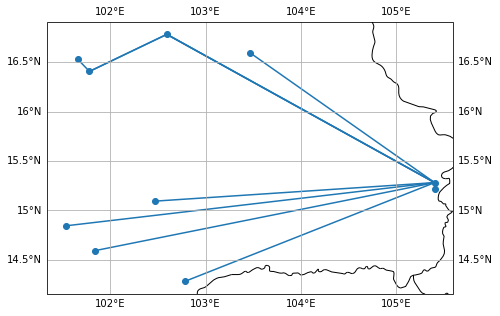

In [53]:

res_network = gpd.GeoDataFrame(data={
    'from_id': from_id,
    'to_id': to_id,
    'from_name': from_name,
    'to_name': to_name,
    'geometry': geoms,
    'length': lengths
})

f, ax = geoax()
res_network.plot(ax=ax)
grid_pts_joined_stns.dropna().to_crs('epsg:4326').plot(marker='o', ax=ax)

ax.gridlines(draw_labels=True)

In [47]:
res_network.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   from_id    12 non-null     float64 
 1   to_id      12 non-null     float64 
 2   from_name  12 non-null     object  
 3   to_name    12 non-null     object  
 4   geometry   12 non-null     geometry
 5   length     12 non-null     float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 704.0+ bytes


In [46]:
# Save `res_network` for further use
save_fn = "../data/thai_network/reservoir_network.shp"  # even though .shp is not ideal, landlab uses this format to initialize. Create an issue in landlab.io?
res_network.to_file(save_fn)

/Users/pdas47/phd/rat_v2/extras/2022_03_29-upstream_regulation/conda-env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [55]:
grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.replace('reservoir_network', 'reservoir_network_pts'))

/Users/pdas47/phd/rat_v2/extras/2022_03_29-upstream_regulation/conda-env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/2y/h464qnw52wq0lwvhs1s03dy40000gp/T/ipykernel_69811/64901592.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.replace('reservoir_network', 'reservoir_network_pts'))
